# Flow modelling test datasets

In [2]:
import graph_tool as gt
import graph_tool.draw
import numpy as np
import datetime
import cairo

In [3]:
print("Date:", datetime.datetime.now().date().isoformat())

Date: 2018-11-24


## Test data Packaging

Let's create an test graph that models cucumber production, packaging and consumption.

In [4]:
G = gt.Graph(directed=True)
G.add_vertex(12)
vid = G.new_vertex_property("string")
G.vertex_properties["id"] = vid
G.vp.id[0] = 'Farm'
G.vp.id[1] = 'Packaging'
G.vp.id[2] = 'Oil rig'
G.vp.id[3] = 'Oil refinery'
G.vp.id[4] = 'Stock 1'
G.vp.id[5] = 'Production'
G.vp.id[6] = 'Consumption'
G.vp.id[7] = 'Waste'
G.vp.id[8] = 'Burn'
G.vp.id[9] = 'Recycling'
G.vp.id[10] = 'Stock 2'
G.vp.id[11] = 'Waste 2'
flow = G.new_edge_property("object")
eid = G.new_edge_property("int") # need a persistent edge id, because graph-tool can reindex the edges
G.edge_properties["flow"] = flow
G.edge_properties["eid"] = eid
G.add_edge(G.vertex(0), G.vertex(1))
G.add_edge(G.vertex(2), G.vertex(3))
G.add_edge(G.vertex(3), G.vertex(4))
G.add_edge(G.vertex(3), G.vertex(5))
G.add_edge(G.vertex(5), G.vertex(1))
G.add_edge(G.vertex(1), G.vertex(6))
G.add_edge(G.vertex(6), G.vertex(7))
G.add_edge(G.vertex(6), G.vertex(8))
G.add_edge(G.vertex(6), G.vertex(9))
G.add_edge(G.vertex(9), G.vertex(10))
G.add_edge(G.vertex(9), G.vertex(5))
G.add_edge(G.vertex(6), G.vertex(11))
G.ep.flow[(0,1)] = {'mass':95, 'composition':{'cucumber':0.3158, 'milk':0.6842}}
G.ep.eid[(0,1)] = 0
G.ep.flow[(2,3)] = {'mass':20, 'composition':{'crude oil':1.0}}
G.ep.eid[(2,3)] = 1
G.ep.flow[(3,4)] = {'mass':16, 'composition':{'petrol':1.0}}
G.ep.eid[(3,4)] = 2
G.ep.flow[(3,5)] = {'mass':4, 'composition':{'plastic':1.0}}
G.ep.eid[(3,5)] = 3
G.ep.flow[(5,1)] = {'mass':5, 'composition':{'plastic':1.0}}
G.ep.eid[(5,1)] = 4
G.ep.flow[(1,6)] = {'mass':100, 'composition':{'plastic':0.05, 'cucumber':0.3, 'milk':0.65}}
G.ep.eid[(1,6)] = 5
G.ep.flow[(6,7)] = {'mass':75, 'composition':{'human waste':1.0}}
G.ep.eid[(6,7)] = 6
G.ep.flow[(6,8)] = {'mass':3, 'composition':{'plastic':1.0}}
G.ep.eid[(6,8)] = 7
G.ep.flow[(6,9)] = {'mass':2, 'composition':{'plastic':1.0}}
G.ep.eid[(6,9)] = 8
G.ep.flow[(9,10)] = {'mass':1, 'composition':{'waste':1.0}}
G.ep.eid[(9,10)] = 9
G.ep.flow[(9,5)] = {'mass':1, 'composition':{'plastic':1.0}}
G.ep.eid[(9,5)] = 10
G.ep.flow[(6,11)] = {'mass':20, 'composition':{'other waste':1.0}}
G.ep.eid[(6,11)] = 11

In [5]:
G.save("cucumba.gt")

In [6]:
t = (i for i in G.ep.flow)
txt = G.new_edge_property("string", vals=t)

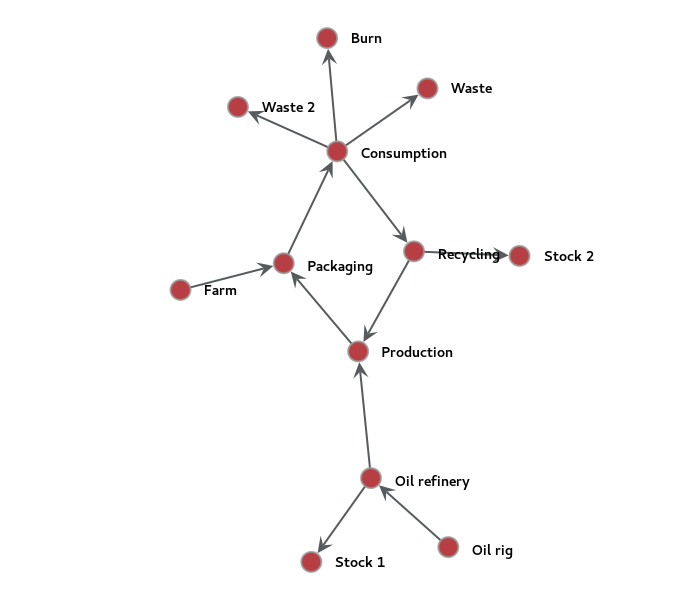

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7ff55f4fd8d0, at 0x7ff55f4fd6a0>

In [7]:
gt.draw.graph_draw(G, vertex_size=20, vertex_text=G.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   output_size=(700,600), inline=True)

## Flow splitting

In the GDSE, flows have two properties, *mass* [tons] and *material composition* [fraction]. In order to compute stuff in the graph, the flows (edges) need to be split per material, often resulting in paralell edges.

In [8]:
def split_flows(G):
    """Split the flows based on material composition
    
    If a flow is composed of different materials, it is split into individual flows per material 
    with the corresponding mass.
    If the flow is composed of a single material, the composition property is removed and replaced with material.
    
    Returns
    -------
    graph
        The updated graph
    eprop_material
        Edge property (materials), string
    eprop_mass
        Edge property (mass), double
    vtx_mask
        Vertex property, bool
    """
    g = G.copy()
    g.clear_edges()
    del g.edge_properties['flow']
    eprops = G.edge_properties.keys()
    mass_list = []
    material_list = []
    assert 'flow' in eprops, "The graph must have 'flow' edge property"
    e_list = []
    for e in G.edges():
        prop = G.ep.flow[e]
        assert isinstance(prop, dict), "Edge property flow must be a dictionary in edge {}".format(e)
        for material, percent in prop['composition'].items():
            e_list.append(np.array([e.source(), e.target()], dtype=int))
            mass_list.append(float(prop['mass']) * float(percent))
            material_list.append(material)
    e_array = np.vstack(e_list)
    g.add_edge_list(e_array)
    eprop_mass = g.new_edge_property("float", vals=mass_list)
    eprop_mass_text = g.new_edge_property("string", vals=[round(i,2) for i in mass_list])
    eprop_material = g.new_edge_property("string", vals=material_list)
    r = (False for x in g.get_vertices())
    vtx_mask = g.new_vertex_property("bool", vals=r)
    return (g, eprop_material, eprop_mass, eprop_mass_text, vtx_mask)

In [9]:
g_split, eprop_material, eprop_mass, eprop_mass_text, vtx_mask = split_flows(G)

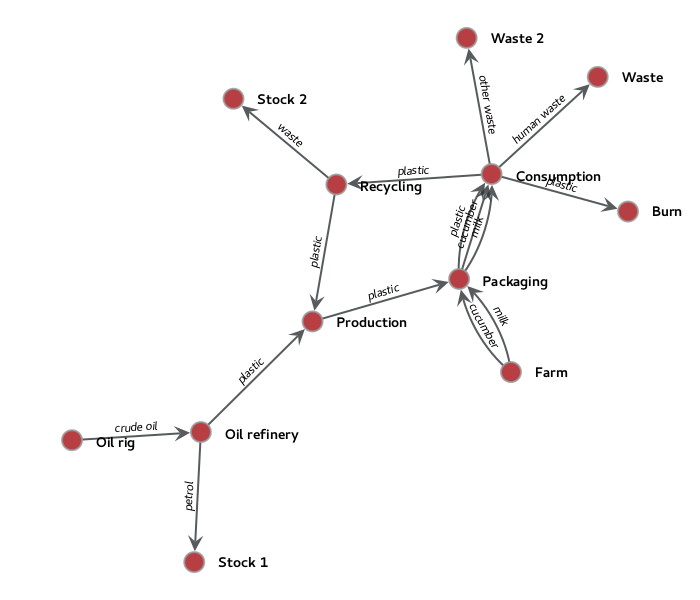

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7ff55f482588, at 0x7ff55f35c3c8>

In [34]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC},
                   edge_text=eprop_material,
                   output_size=(700,600), inline=True,
                   output="cucumba.pdf", fmt="pdf")

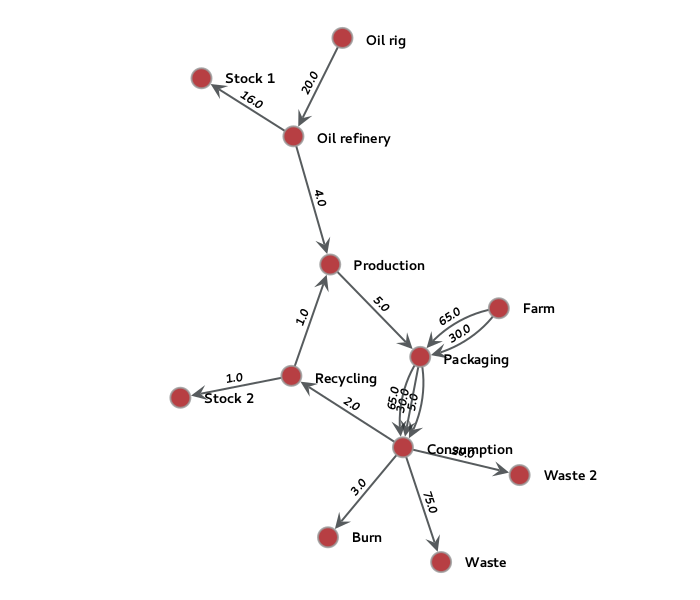

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7ff55f482588, at 0x7ff55f35c4a8>

In [35]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "text":eprop_mass_text, "font_weight": cairo.FONT_WEIGHT_BOLD},
                   output_size=(700,600), inline=True,
                  output="cucumba_mass.pdf", fmt="pdf")

## Test data Bread to Beer

In [27]:
del G
G = gt.Graph(directed=True)
G.add_vertex(6)
vid = G.new_vertex_property("string")
G.vertex_properties["id"] = vid
G.vp.id[0] = 'Households'
G.vp.id[1] = 'Incineration'
G.vp.id[2] = 'Digester'
G.vp.id[3] = 'Brewery'
G.vp.id[4] = 'Supermarkets'
G.vp.id[5] = 'Farm'
flow = G.new_edge_property("object")
G.edge_properties["flow"] = flow
G.add_edge(G.vertex(0), G.vertex(1))
G.add_edge(G.vertex(0), G.vertex(2))
G.add_edge(G.vertex(3), G.vertex(2))
G.add_edge(G.vertex(3), G.vertex(4))
G.add_edge(G.vertex(5), G.vertex(3))
G.ep.flow[(0,1)] = {'mass':20, 'composition':{'bread':0.25, 'other waste':0.75}}
G.ep.flow[(0,2)] = {'mass':10, 'composition':{'bread':1.0}}
G.ep.flow[(3,2)] = {'mass':20, 'composition':{'sludge':1.0}}
G.ep.flow[(3,4)] = {'mass':40, 'composition':{'beer':1.0}}
G.ep.flow[(5,3)] = {'mass':9, 'composition':{'barley':1.0}}

G.save("breadbeer.gt")

In [28]:
t = (i for i in G.ep.flow)
txt = G.new_edge_property("string", vals=t)

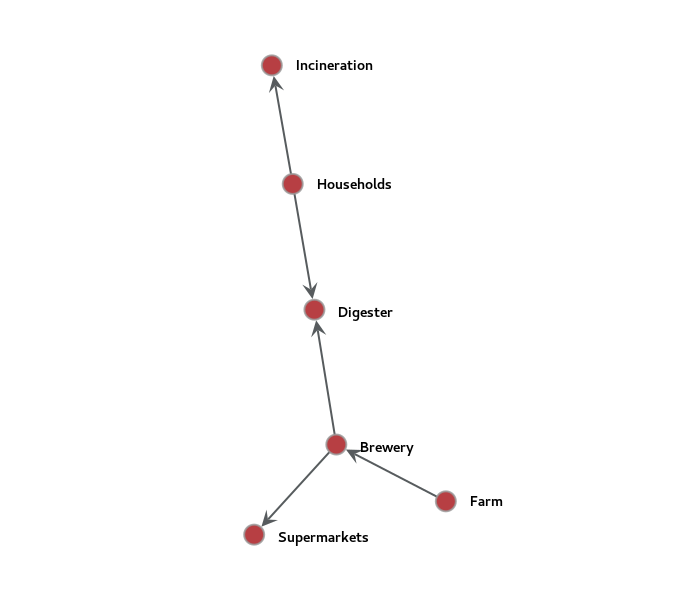

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fdaac26f358, at 0x7fdaaa53d080>

In [29]:
gt.draw.graph_draw(G, vertex_size=20, vertex_text=G.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   output_size=(700,600), inline=True)

In [30]:
g_split, eprop_material, eprop_mass, eprop_mass_text, vtx_mask = split_flows(G)

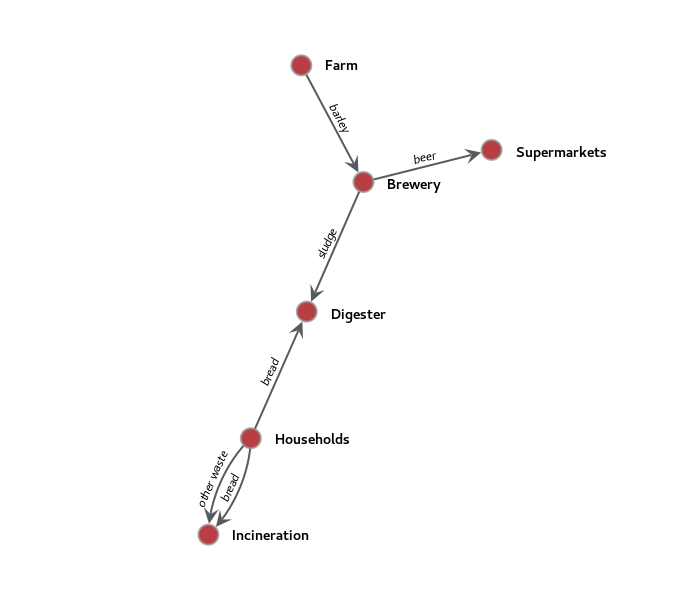

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fdaaa53d828, at 0x7fdaaa4fbe80>

In [31]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC},
                   edge_text=eprop_material,
                   output_size=(700,600), inline=True)

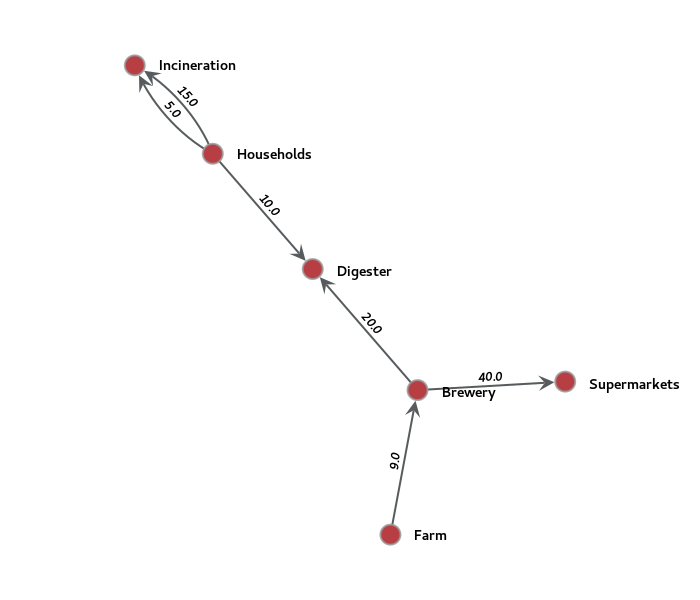

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fdaaa53d828, at 0x7fdaaa4fb438>

In [32]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "text":eprop_mass_text, "font_weight": cairo.FONT_WEIGHT_BOLD},
                   output_size=(700,600), inline=True)